# Lecture 03 - Multiple Linear Regression

## Import Required Libraries

In [ ]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import r2_score

In [ ]:
!pip install dmba

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 6.8 MB/s eta 0:00:00
Colab environment detected.


## Load the Data

In [ ]:
my_drive_path = "/content/drive/MyDrive/SUNY/Class Material/2024 Fall/MSA550A/Python Class Work/msa550-code-files/data/"

In [ ]:
car_df = pd.read_csv(my_drive_path+'ToyotaCorolla.csv')
print(car_df.head(5))
car_df.columns

   Id                                          Model  Price  Age_08_04  \
0   1  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13500         23   
1   2  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13750         23   
2   3  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  13950         24   
3   4  TOYOTA Corolla 2.0 D4D HATCHB TERRA 2/3-Doors  14950         26   
4   5    TOYOTA Corolla 2.0 D4D HATCHB SOL 2/3-Doors  13750         30   

   Mfg_Month  Mfg_Year     KM Fuel_Type  HP  Met_Color  ... Powered_Windows  \
0         10      2002  46986    Diesel  90          1  ...               1   
1         10      2002  72937    Diesel  90          1  ...               0   
2          9      2002  41711    Diesel  90          1  ...               0   
3          7      2002  48000    Diesel  90          0  ...               0   
4          3      2002  38500    Diesel  90          0  ...               1   

   Power_Steering  Radio  Mistlamps  Sport_Model  Backseat_Divider  \
0         

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors',
       'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee',
       'BOVAG_Guarantee', 'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2',
       'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player',
       'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio',
       'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim',
       'Radio_cassette', 'Parking_Assistant', 'Tow_Bar'],
      dtype='object')

## Preprocessing the Data

### Handling Missing Values
Remember, the fact that it has no null values, does not mean no missing values.

In [1]:
print("Missing values:\n", car_df.isnull().sum())

NameError: name 'car_df' is not defined

### Correlation Table
Multicollinearity check, variable relationship etc.

In [ ]:
numeric_columns = car_df.select_dtypes(include=[np.number]).columns

# Create a new DataFrame with only numeric columns
numeric_df = car_df[numeric_columns]

correlation_matrix = numeric_df.corr()
#print(correlation_matrix)

fig = go.Figure(data=go.Heatmap(
                z=correlation_matrix.values,
                x=correlation_matrix.columns,
                y=correlation_matrix.index,
                colorscale='RdBu',
                zmin=-1, zmax=1,
                text=correlation_matrix.values,
                texttemplate='%{text:.2f}',
                hoverongaps=False))

# Update the layout
fig.update_layout(
    title='Correlation Matrix',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,  # Adjust the width as needed
    height=700  # Adjust the height as needed
)

# Show the plot
fig.show()

1. Strong correlations with Price:
* Age_08_04 has a strong negative correlation (-0.876590) with Price, indicating that older cars tend to be cheaper.
* Mfg_Year has a strong positive correlation (0.885159) with Price, which is consistent with the Age correlation.
* KM (kilometers) has a moderate negative correlation (-0.569960) with Price, suggesting that cars with higher mileage tend to be cheaper.

2. Multicollinearity:
* Age_08_04 and Mfg_Year are highly correlated (-0.983661), which is expected as they represent similar information. **drop Mfg_Year**
* Id seems to be correlated with several variables, which is unusual and might indicate it's not just a simple identifier. **drop Id**

3. Lack of correlation:
* Some features like Radio, Power_Steering, and Metallic_Rim show very weak correlations with Price. **will drop them**

4. Potential redundant features:
* Radio and Radio_cassette are highly correlated (0.991621), suggesting they might be redundant. *drop them - (radio was also mentioned in point 3)**

In [ ]:
# for Radio_cassette, Radio, Power_Steering, and Metallic_Rim, Mfg_Year Id we planned to drop them already

#in addition: CD_Player, Backseat_Divider, BOVAG_Guarantee, Guarantee_Period, ABS, Automatic_airco

columns_to_drop = ['Radio_cassette', 'Radio', 'Power_Steering', 'Metallic_Rim', 'Mfg_Year', 'Id','CD_Player','Backseat_Divider','BOVAG_Guarantee','Guarantee_Period','Automatic_airco','ABS']

car_df = car_df.drop(columns=columns_to_drop)

print("Columns dropped successfully.")
print(f"Remaining columns: {car_df.columns.tolist()}")

Columns dropped successfully.
Remaining columns: ['Model', 'Price', 'Age_08_04', 'Mfg_Month', 'KM', 'Fuel_Type', 'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'Airbag_1', 'Airbag_2', 'Airco', 'Boardcomputer', 'Central_Lock', 'Powered_Windows', 'Mistlamps', 'Sport_Model', 'Parking_Assistant', 'Tow_Bar']


### Check for Outliers

In [ ]:
# 4. Check for outliers
numeric_columns = car_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create subplots, one for each numeric column
fig = make_subplots(rows=1, cols=len(numeric_columns),
                    subplot_titles=numeric_columns)

# Add box plots for each numeric column
for i, col in enumerate(numeric_columns):
    fig.add_trace(
        go.Box(y=car_df[col], name=col),
        row=1, col=i+1
    )

# Update layout
fig.update_layout(
    title_text="Boxplots to Check for Outliers",
    height=600,
    width=200 * len(numeric_columns),  # Adjust width based on number of plots
    showlegend=False
)

# Update x-axis
fig.update_xaxes(visible=False)  # Hide x-axis labels as they're not needed for boxplots

# Show plot
fig.show()

In [ ]:
#outlier stats
numeric_columns = car_df.select_dtypes(include=['int64', 'float64']).columns

outlier_percentages = {}

# Print summary statistics for each numeric column
for column in numeric_columns:
    print(f"\nSummary statistics for {column}:")
    print(car_df[column].describe())
    print("\nPotential outliers:")
    Q1 = car_df[column].quantile(0.25)
    Q3 = car_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = car_df[(car_df[column] < lower_bound) | (car_df[column] > upper_bound)][column]
    print(outliers)

    # Calculate percentage of outliers
    outlier_percentage = (len(outliers) / len(car_df)) * 100
    outlier_percentages[column] = outlier_percentage

    print(f"Percentage of outliers: {outlier_percentage:.2f}%")
    print("--------------------")

# Print total percentage of outliers for each parameter
print("\nTotal percentage of outliers for each parameter:")
for column, percentage in outlier_percentages.items():
    print(f"{column}: {percentage:.2f}%")


Summary statistics for Price:
count     1436.000000
mean     10730.824513
std       3626.964585
min       4350.000000
25%       8450.000000
50%       9900.000000
75%      11950.000000
max      32500.000000
Name: Price, dtype: float64

Potential outliers:
7      18600
8      21500
10     20950
11     19950
12     19600
       ...  
182    21125
183    21500
184    17795
185    18245
523    18950
Name: Price, Length: 110, dtype: int64
Percentage of outliers: 7.66%
--------------------

Summary statistics for Age_08_04:
count    1436.000000
mean       55.947075
std        18.599988
min         1.000000
25%        44.000000
50%        61.000000
75%        70.000000
max        80.000000
Name: Age_08_04, dtype: float64

Potential outliers:
109    4
110    4
111    4
182    2
183    2
184    1
185    1
Name: Age_08_04, dtype: int64
Percentage of outliers: 0.49%
--------------------

Summary statistics for Mfg_Month:
count    1436.000000
mean        5.548747
std         3.354085
min         1

In [ ]:
def remove_outliers(df, columns):
    df_clean = df.copy()
    total_removed = 0
    total_data = len(df) * len(columns)

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        df_clean = df_clean[~df_clean.index.isin(outliers.index)]

        num_removed = len(outliers)
        total_removed += num_removed

        print(f"Column {column}:")
        print(f"  Number of outliers removed: {num_removed}")
        print(f"  Percentage of data removed: {(num_removed / len(df)) * 100:.2f}%")
        print("--------------------")

    overall_percentage = (total_removed / total_data) * 100
    print(f"\nOverall percentage of data points removed: {overall_percentage:.2f}%")
    print(f"Number of rows in original dataset: {len(df)}")
    print(f"Number of rows in cleaned dataset: {len(df_clean)}")

    return df_clean

print(car_df.shape)
# Remove outliers - be careful with this one!!!
car_df_clean = remove_outliers(car_df, numeric_columns)
car_df_clean.shape

(1436, 27)
Column Price:
  Number of outliers removed: 110
  Percentage of data removed: 7.66%
--------------------
Column Age_08_04:
  Number of outliers removed: 7
  Percentage of data removed: 0.49%
--------------------
Column Mfg_Month:
  Number of outliers removed: 0
  Percentage of data removed: 0.00%
--------------------
Column KM:
  Number of outliers removed: 49
  Percentage of data removed: 3.41%
--------------------
Column HP:
  Number of outliers removed: 11
  Percentage of data removed: 0.77%
--------------------
Column Met_Color:
  Number of outliers removed: 0
  Percentage of data removed: 0.00%
--------------------
Column Automatic:
  Number of outliers removed: 80
  Percentage of data removed: 5.57%
--------------------
Column CC:
  Number of outliers removed: 123
  Percentage of data removed: 8.57%
--------------------
Column Doors:
  Number of outliers removed: 0
  Percentage of data removed: 0.00%
--------------------
Column Cylinders:
  Number of outliers removed: 

(978, 27)

### Encode Categorical Variables

In [ ]:
# 5. Encode categorical variables
car_df_model = pd.get_dummies(car_df, columns=['Fuel_Type'], drop_first=True)

In [ ]:
car_df_model.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Cylinders',
       'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol'],
      dtype='object')

### Scale Numerical Variables


In [ ]:
scaler = StandardScaler()
#hand picked them
numerical_columns = ['Age_08_04', 'KM', 'HP', 'CC', 'Weight']
car_df_model[numerical_columns] = scaler.fit_transform(car_df[numerical_columns])

### Feature Engineering and Transformations
You can create new features to better represent data.
You can transform variables as well

In [ ]:
# Feature engineering (example)  -- It captures the relationship between price and mileage in a single feature
car_df['Price_per_KM'] = car_df['Price'] / (car_df['KM'] + 1)  # Adding 1 to avoid division by zero


# Logarithmic transformation of Price - It can help normalize the distribution of prices if they are right-skewed
car_df['Log_Price'] = np.log(car_df['Price']) #In economic models, log-transformations are often used because many economic phenomena follow log-normal distributions.


In [ ]:
# Additional: Check VIF for multicollinearity
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

print("VIF:\n", calculate_vif(numeric_df))

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning:

divide by zero encountered in scalar divide



VIF:
              Variable        VIF
0                  Id  13.780509
1               Price  10.921213
2           Age_08_04        inf
3           Mfg_Month        inf
4            Mfg_Year        inf
5                  KM   3.175433
6                  HP   1.741414
7           Met_Color   1.142551
8           Automatic   1.115682
9                  CC   1.222698
10              Doors   1.261459
11          Cylinders   0.000000
12              Gears   1.282043
13      Quarterly_Tax   2.865925
14             Weight   3.459321
15      Mfr_Guarantee   1.228304
16    BOVAG_Guarantee   1.393054
17   Guarantee_Period   1.593722
18                ABS   2.341555
19           Airbag_1   1.600533
20           Airbag_2   3.091520
21              Airco   1.849285
22    Automatic_airco   2.028305
23      Boardcomputer   2.648891
24          CD_Player   1.556553
25       Central_Lock   4.609259
26    Powered_Windows   4.665527
27     Power_Steering   1.560597
28              Radio  62.408604
29  

## Split the Data

In [ ]:
car_df_model.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'HP', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Cylinders',
       'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol'],
      dtype='object')

In [ ]:
# 'Age_08_04', 'KM', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Weight'

predictors = ['Age_08_04', 'KM', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'HP', 'Met_Color', 'Automatic', 'CC', 'Doors', 'Quarterly_Tax', 'Weight']
outcome = 'Price'

#select only top 1000 records
#car_df_model = car_df_model.head(1000)



X = car_df_model[predictors]
y = car_df_model[outcome]





train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=42)

## Build the Model

In [ ]:
car_lm = LinearRegression()
car_lm.fit(train_X, train_y)

# print coefficients
print('intercept ', car_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': car_lm.coef_}))

# print performance measures
regressionSummary(train_y, car_lm.predict(train_X))

intercept  7554.894372892892
           Predictor  coefficient
0          Age_08_04 -2224.516781
1                 KM  -584.682158
2   Fuel_Type_Diesel   130.027545
3   Fuel_Type_Petrol  2721.981942
4                 HP   218.311611
5          Met_Color    79.815502
6          Automatic   146.329618
7                 CC    -9.835220
8              Doors   -95.371922
9      Quarterly_Tax    12.851918
10            Weight  1219.970585

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1280.6107
            Mean Absolute Error (MAE) : 958.5209
          Mean Percentage Error (MPE) : -1.1286
Mean Absolute Percentage Error (MAPE) : 9.5194


Component	Coefficient	Explanation
* Intercept	6619.77	The baseline value when all predictors are zero
* Age_08_04	-2307.65	For each unit increase in age, price decreases by 2,307.65
* KM	-602.10	For each additional kilometer, price decreases by 602.10
* Fuel_Type_Diesel	4481.09	Diesel cars are priced 4,481.09 higher than the baseline fuel type
* Fuel_Type_Petrol	2413.06	Petrol cars are priced 2,413.06 higher than the baseline fuel type
* HP	1131.41	Each additional horsepower increases price by 1,131.41
* Met_Color	47.72	Metallic color adds 47.72 to the price
* Automatic	462.44	Automatic transmission adds 462.44 to the price
* CC	-2132.90	Each unit increase in engine size decreases price by 2,132.90
* Doors	58.42	Each additional door adds 58.42 to the price
* Quarterly_Tax	13.01	Each unit increase in quarterly tax adds 13.01 to the price
* Weight	744.94	Each unit increase in weight adds 744.94 to the price

Key Insights:
* Age and mileage (KM) have negative impacts on price, as expected for used cars.
* Diesel fuel type has the strongest positive effect on price.
* Horsepower (HP) and weight positively influence price, indicating a premium for powerful and larger vehicles.
* Engine size (CC) surprisingly has a negative correlation, possibly due to fuel efficiency concerns.
* Automatic transmission adds value to the car.
* The number of doors and metallic color have minor positive impacts on price.

Statistic	Value
* Mean Error (ME)	-0.0000
* Root Mean Squared Error (RMSE)	1315.5318
* Mean Absolute Error (MAE)	953.7443
* Mean Percentage Error (MPE)	-1.0544
* Mean Absolute Percentage Error (MAPE)	9.2370

Interpretation:
* ME: The average of all errors is essentially zero, indicating unbiased predictions.
* RMSE: On average, predictions deviate from actual values by about 1,316 units.
* MAE: The average absolute difference between predicted and actual values is about 954 units.
* MPE: On average, predictions underestimate actual values by about 1.05%.
* MAPE: The average absolute percentage error is 9.24%, suggesting reasonable accuracy.

Key Takeaways:
* The model shows no systematic bias (ME ≈ 0).
* Predictions are generally within 9.24% of actual values.
* There's room for improvement, but the model provides useful estimates.

In [ ]:
#just for checking purposes
pred_y = car_lm.predict(train_X)

print('adjusted r2 : ', adjusted_r2_score(train_y, pred_y, car_lm))
#how to decide the number of features?
#find a model than falls in a good score with AIC and BIC. The higher AIC, you need to include more features, the higher BIC,
#you need to drop some features.
#Akaike Information Criterion
print('AIC : ', AIC_score(train_y, pred_y, car_lm))
#Bayesian Information Criterion
print('BIC : ', BIC_score(train_y, pred_y, car_lm))

adjusted r2 :  0.8705872475538429
AIC :  17259.802010824355
BIC :  17323.667667490765


## Make Predictions

In [ ]:
car_lm_pred = car_lm.predict(valid_X)

result = pd.DataFrame({'Predicted': car_lm_pred, 'Actual': valid_y,
                       'Residual': valid_y - car_lm_pred})

print(result.head(10))

regressionSummary(valid_y, car_lm_pred)

         Predicted  Actual     Residual
594   11224.917826   10800  -424.917826
754    9254.096208    9950   695.903792
630    9447.090164    7500 -1947.090164
1259   9121.204073    9250   128.795927
903    9292.017723    9750   457.982277
1175   8110.270149    9950  1839.729851
762    8733.840867    9895  1161.159133
1372   8336.643803    6750 -1586.643803
259   14158.538702   13450  -708.538702
316   13185.411949   12950  -235.411949

Regression statistics

                      Mean Error (ME) : -103.5613
       Root Mean Squared Error (RMSE) : 1403.5975
            Mean Absolute Error (MAE) : 968.3501
          Mean Percentage Error (MPE) : -2.2983
Mean Absolute Percentage Error (MAPE) : 9.4610


Metric	Value	Interpretation
* Mean Error (ME)	190.6887	Slight positive bias in predictions
* Root Mean Squared Error (RMSE)	3315.7836	Average deviation of predictions
* Mean Absolute Error (MAE)	1095.1592	Average absolute difference in predictions
* Mean Percentage Error (MPE)	0.2537%	Minimal overall percentage bias
* Mean Absolute Percentage Error (MAPE)	10.3465%	Average percentage deviation

Key Insights:
* The model shows a slight tendency to overpredict (positive ME).
* On average, predictions deviate from actual values by about 3,316 units (RMSE).
* The average absolute difference between predicted and actual values is 1,095 units (MAE).
* Predictions are, on average, within 10.35% of the actual values (MAPE).

Model Performance:
* The low MPE (0.2537%) suggests that the model is relatively unbiased overall.
* A MAPE of 10.3465% indicates moderate accuracy, with predictions typically within about 10% of actual values.
* The RMSE (3315.7836) is higher than the MAE (1095.1592), suggesting some larger errors are present.

Recommendations:
* The model provides useful estimates but there's room for improvement.
* Consider investigating outliers or influential points that may be causing larger errors.
* Explore non-linear relationships or additional features to potentially improve accuracy.
* Use the MAPE to communicate that predictions are generally within about 10% of actual values.

## Investigate Residuals

0.7563805104408353


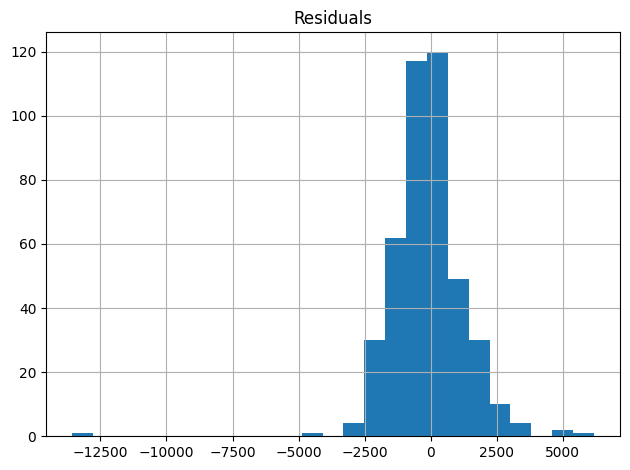

In [ ]:
car_lm_pred = car_lm.predict(valid_X)
all_residuals = valid_y - car_lm_pred

# Determine the percentage of datapoints with a residual in [-1406, 1406] = approx. 75\%
print(len(all_residuals[(all_residuals > -1406) & (all_residuals < 1406)]) / len(all_residuals))

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#notice that most of the errors are between 2000

Percentage of residuals within [-1406, 1406]: 75.64%


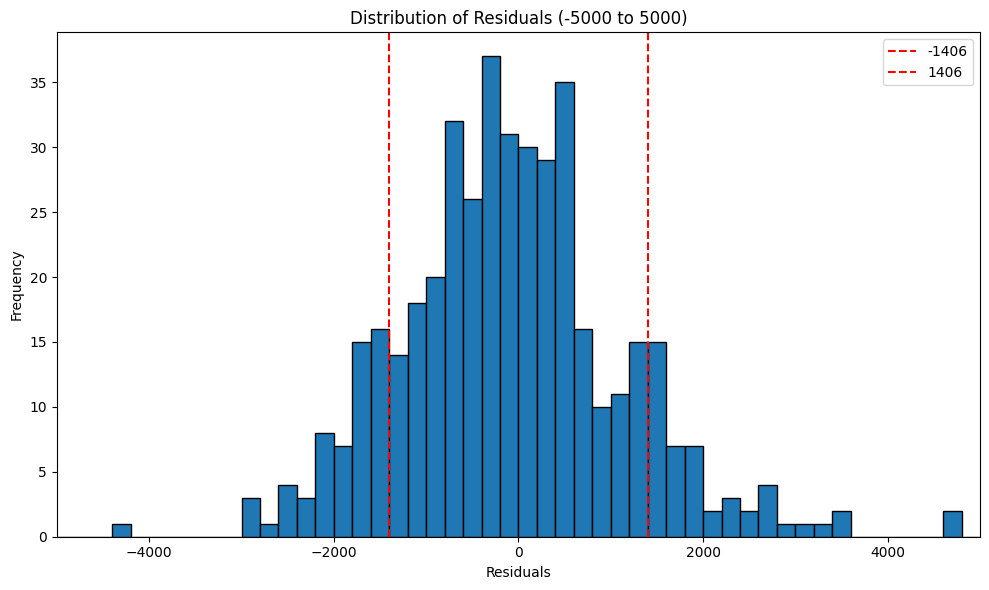

In [ ]:
# Calculate percentage of datapoints within [-1406, 1406]
within_range = np.sum((all_residuals >= -1406) & (all_residuals <= 1406)) / len(all_residuals)
print(f"Percentage of residuals within [-1406, 1406]: {within_range:.2%}")

# Create histogram with focus on -5000 to 5000
plt.figure(figsize=(10, 6))
plt.hist(all_residuals, bins=np.linspace(-5000, 5000, 51), edgecolor='black')
plt.xlim(-5000, 5000)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (-5000 to 5000)')

# Add vertical lines at -1406 and 1406
plt.axvline(x=-1406, color='red', linestyle='--', label='-1406')
plt.axvline(x=1406, color='red', linestyle='--', label='1406')

plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# you could do the same with plotly, should make it easier to zoom


# Calculate the percentage of datapoints with residuals in [-1406, 1406]
percentage = np.sum((all_residuals > -1406) & (all_residuals < 1406)) / len(all_residuals)

# Create a DataFrame for the residuals
df_residuals = pd.DataFrame({'Residuals': all_residuals})

# Create the histogram using Plotly
fig = go.Figure(data=[go.Histogram(x=df_residuals['Residuals'], nbinsx=25)])

# Update layout
fig.update_layout(
    title=f"Histogram of Residuals<br><sup>{percentage:.2%} of residuals are between -1406 and 1406</sup>",
    xaxis_title="Residuals",
    yaxis_title="Frequency",
    bargap=0.1
)

# Show the plot
fig.show()

In [ ]:
# Calculate percentage of datapoints within [-1406, 1406]
within_range = np.sum((all_residuals >= -1406) & (all_residuals <= 1406)) / len(all_residuals)
percentage_text = f"Percentage of residuals within [-1406, 1406]: {within_range:.2%}"

# Create histogram trace
hist_trace = go.Histogram(
    x=all_residuals,
    xbins=dict(start=-5000, end=5000, size=(5000-(-5000))/50),
    marker_line_width=1,
    marker_line_color="black",
    name="Residuals"
)

# Create vertical line traces
line_minus = go.Scatter(
    x=[-1406, -1406], y=[0, 1],
    mode="lines",
    name="-1406",
    line=dict(color="red", dash="dash")
)

line_plus = go.Scatter(
    x=[1406, 1406], y=[0, 1],
    mode="lines",
    name="1406",
    line=dict(color="red", dash="dash")
)

# Create the figure
fig = go.Figure(data=[hist_trace, line_minus, line_plus])

# Update layout
fig.update_layout(
    title=f"Distribution of Residuals (-5000 to 5000)<br><sup>{percentage_text}</sup>",
    xaxis_title="Residuals",
    yaxis_title="Frequency",
    xaxis_range=[-5000, 5000],
    showlegend=True,
    legend_title_text="Legend",
    width=800,
    height=500
)

# Update y-axis to show full range
fig.update_yaxes(rangemode="tozero")

# Show the plot
fig.show()

## Investigate Data Points

In [ ]:
all_residuals.describe()

,Price
count,431.000000
mean,-103.561257
std,1401.398501
min,-13567.329955
25%,-854.722973
50%,-141.779745
75%,533.568271
max,6175.244534


In [ ]:
#Example on how to check particular records
max_residual_index = result['Residual'].idxmax()
max_residual_row_result = result.loc[max_residual_index]
max_residual_row_car = car_df_model.loc[max_residual_index]

In [ ]:
max_residual_row_result


,147
Predicted,18324.755466
Actual,24500.000000
Residual,6175.244534


In [ ]:
max_residual_row_car

,147
Id,149
Model,TOYOTA Corolla 1.6 16V VVT I 5DR EXEC BNS 4/5-...
Price,24500
Age_08_04,-2.309788
Mfg_Month,8
Mfg_Year,2003
KM,-1.294769
HP,0.56744
Met_Color,1
Color,Grey


## Linear to Multiple Linear

In [ ]:
import plotly.express as px

fig = px.scatter(car_df, x='Age_08_04', y='Price',
                 labels={'Age_08_04': 'Age', 'Price': 'Price'},
                 title='Age vs Price')
fig.show()

In [ ]:
fig = px.scatter_3d(car_df, x='Age_08_04', y='KM', z='Price',
                    labels={'Age_08_04': 'Age', 'KM': 'Kilometers', 'Price': 'Price'},
                    title='Age, Kilometers, and Price Relationship')
fig.show()

In [ ]:
fig = px.scatter_3d(car_df, x='Age_08_04', y='KM', z='Price', color='HP',
                    labels={'Age_08_04': 'Age', 'KM': 'Kilometers', 'Price': 'Price', 'HP': 'Horsepower'},
                    title='Age, Kilometers, Price, and Horsepower Relationship')
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

x = car_df['Age_08_04']
y = car_df['KM']
z = car_df['Price']

xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xi, yi)

from scipy.interpolate import griddata
Z = griddata((x, y), z, (X, Y), method='cubic')

fig = go.Figure(data=[go.Surface(z=Z, x=xi, y=yi)])
fig.update_layout(title='Price Surface Plot',
                  scene = dict(xaxis_title='Age', yaxis_title='Kilometers', zaxis_title='Price'))
fig.show()

## Selection Method

### Exhaustive Search

In [ ]:
def adjusted_r2_score(y_true, y_pred, model):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = len(model.coef_)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [ ]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    return -adjusted_r2_score(train_y, pred_y, model)

In [ ]:
allVariables = train_X.columns.tolist()
results = exhaustive_search(allVariables, train_model, score_model)

NameError: name 'train_X' is not defined

In [ ]:
# Process results
data = []
for result in results:
    model = result['model']
    variables = result['variables']
    pred_y = model.predict(train_X[variables])
    AIC = AIC_score(train_y, pred_y, model)
    r2adj = -result['score']  # Negate back to positive

    d = {
        'n': result['n'],
        'r2adj': r2adj,
        'AIC': AIC,
        **{var: var in result['variables'] for var in allVariables}
    }
    data.append(d)

# Create and display DataFrame
df_results = pd.DataFrame(data)
df_results = df_results[['n', 'r2adj', 'AIC'] + sorted(allVariables)]
df_results = df_results.sort_values(['r2adj', 'AIC'], ascending=[False, True])

NameError: name 'results' is not defined

In [ ]:
df_results

,n,r2adj,AIC,Age_08_04,Automatic,CC,Doors,Fuel_Type_Diesel,Fuel_Type_Petrol,HP,KM,Met_Color,Quarterly_Tax,Weight
6,7,0.870908,17253.347864,True,False,False,True,False,True,True,True,False,True,True
7,8,0.870886,17254.509345,True,False,False,True,False,True,True,True,True,True,True
8,9,0.870831,17255.932444,True,True,False,True,False,True,True,True,True,True,True
9,10,0.870709,17257.870124,True,True,False,True,True,True,True,True,True,True,True
10,11,0.870587,17259.802011,True,True,True,True,True,True,True,True,True,True,True
5,6,0.870469,17255.765134,True,False,False,False,False,True,True,True,False,True,True
4,5,0.868564,17269.448073,True,False,False,False,False,True,False,True,False,True,True
3,4,0.862406,17314.465462,True,False,False,False,False,True,False,True,False,False,True
2,3,0.848796,17408.264073,True,False,False,False,False,False,False,True,False,False,True
1,2,0.805241,17661.667956,True,False,False,False,False,False,False,False,False,False,True



Best model by adjusted R2:
Number of predictors: 7
Adjusted R2: 0.8709
AIC: 17253.3479
Variables: Age_08_04, KM, Fuel_Type_Petrol, HP, Doors, Quarterly_Tax, Weight

Best model by AIC:
Number of predictors: 7
Adjusted R2: 0.8709
AIC: 17253.3479
Variables: Age_08_04, KM, Fuel_Type_Petrol, HP, Doors, Quarterly_Tax, Weight


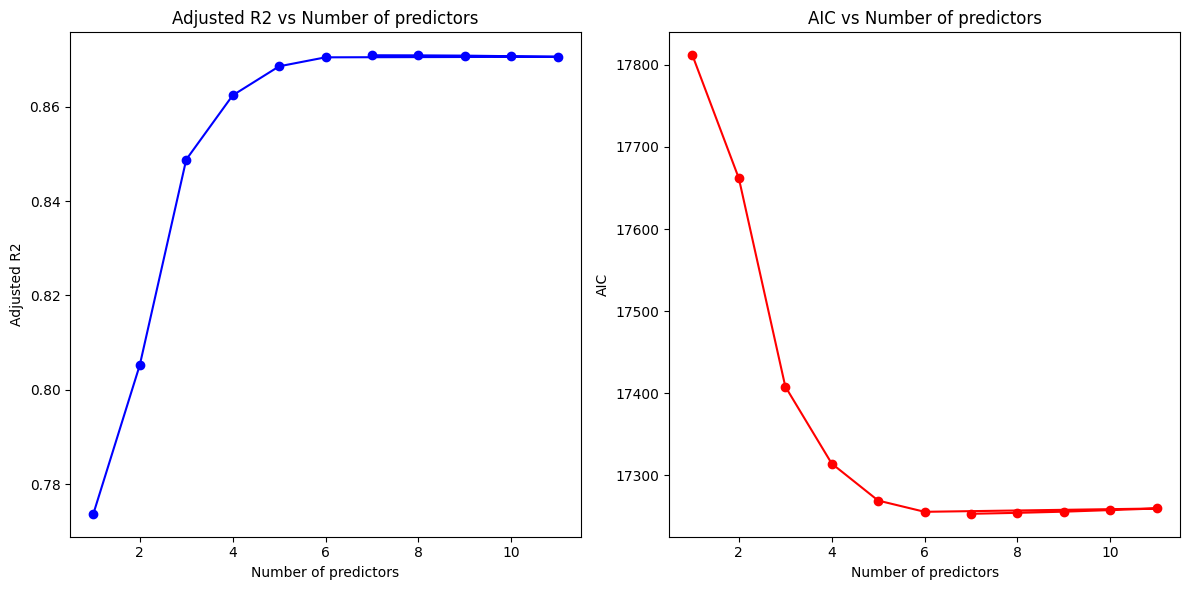

In [ ]:

# Analyze results
best_r2_model = df_results.iloc[0]
print(f"\nBest model by adjusted R2:")
print(f"Number of predictors: {best_r2_model['n']}")
print(f"Adjusted R2: {best_r2_model['r2adj']:.4f}")
print(f"AIC: {best_r2_model['AIC']:.4f}")
print(f"Variables: {', '.join([var for var in allVariables if best_r2_model[var]])}")

best_aic_model = df_results.sort_values('AIC').iloc[0]
print(f"\nBest model by AIC:")
print(f"Number of predictors: {best_aic_model['n']}")
print(f"Adjusted R2: {best_aic_model['r2adj']:.4f}")
print(f"AIC: {best_aic_model['AIC']:.4f}")
print(f"Variables: {', '.join([var for var in allVariables if best_aic_model[var]])}")

# Plot R2 and AIC vs number of predictors
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(df_results['n'], df_results['r2adj'], 'bo-')
plt.xlabel('Number of predictors')
plt.ylabel('Adjusted R2')
plt.title('Adjusted R2 vs Number of predictors')

plt.subplot(1, 2, 2)
plt.plot(df_results['n'], df_results['AIC'], 'ro-')
plt.xlabel('Number of predictors')
plt.ylabel('AIC')
plt.title('AIC vs Number of predictors')

plt.tight_layout()
plt.show()

### backward elimination

In [ ]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

## notice: the chosen 8-feature model is the same as the one from exhaustive search (NOT ALWAYS THIS HAPPENS)

Variables: Age_08_04, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight
Start: score=17259.80
Step: score=17257.87, remove CC
Step: score=17255.93, remove Fuel_Type_Diesel
Step: score=17254.51, remove Automatic
Step: score=17253.35, remove Met_Color
Step: score=17253.35, remove None
['Age_08_04', 'KM', 'Fuel_Type_Petrol', 'HP', 'Doors', 'Quarterly_Tax', 'Weight']


In [ ]:
# Validate the model using only the best variables
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

                      Mean Error (ME) : -103.0754
       Root Mean Squared Error (RMSE) : 1405.9017
            Mean Absolute Error (MAE) : 967.9158
          Mean Percentage Error (MPE) : -2.2935
Mean Absolute Percentage Error (MAPE) : 9.4476


 ### Forward selection

In [ ]:
# The initial model is the constant model - this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight
Start: score=19303.85, constant
Step: score=17811.58, add Age_08_04
Step: score=17661.67, add Weight
Step: score=17408.26, add KM
Step: score=17314.47, add Fuel_Type_Petrol
Step: score=17269.45, add Quarterly_Tax
Step: score=17255.77, add HP
Step: score=17253.35, add Doors
Step: score=17253.35, add None
['Age_08_04', 'Weight', 'KM', 'Fuel_Type_Petrol', 'Quarterly_Tax', 'HP', 'Doors']


### Stepwise Selection

In [ ]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: Age_08_04, KM, Fuel_Type_Diesel, Fuel_Type_Petrol, HP, Met_Color, Automatic, CC, Doors, Quarterly_Tax, Weight
Start: score=19303.85, constant
Step: score=17811.58, add Age_08_04
Step: score=17661.67, add Weight
Step: score=17408.26, add KM
Step: score=17314.47, add Fuel_Type_Petrol
Step: score=17269.45, add Quarterly_Tax
Step: score=17255.77, add HP
Step: score=17253.35, add Doors
Step: score=17253.35, unchanged None
['Age_08_04', 'Weight', 'KM', 'Fuel_Type_Petrol', 'Quarterly_Tax', 'HP', 'Doors']


## Regularized Methods [Shrinkage]

In [ ]:
# Lasso Regression
lasso = Lasso(alpha=1)  # Note: normalize=True is deprecated, use StandardScaler instead
lasso.fit(train_X, train_y)  # Fit the model to the training data
print("Lasso Regression Results:")
regressionSummary(valid_y, lasso.predict(valid_X))  # Evaluate on validation set

Lasso Regression Results:

Regression statistics

                      Mean Error (ME) : -104.7963
       Root Mean Squared Error (RMSE) : 1403.3557
            Mean Absolute Error (MAE) : 968.5316
          Mean Percentage Error (MPE) : -2.3165
Mean Absolute Percentage Error (MAPE) : 9.4638


In [ ]:
# Lasso CV (Cross-Validation)
lasso_cv = LassoCV(cv=5)  # 5-fold cross-validation
lasso_cv.fit(train_X, train_y)
print("\nLasso CV Results:")
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print(f'Lasso-CV chosen regularization: {lasso_cv.alpha_:.4f}')
print("Lasso CV Coefficients:", lasso_cv.coef_)


Lasso CV Results:

Regression statistics

                      Mean Error (ME) : -121.9520
       Root Mean Squared Error (RMSE) : 1397.2369
            Mean Absolute Error (MAE) : 1004.7808
          Mean Percentage Error (MPE) : -2.7737
Mean Absolute Percentage Error (MAPE) : 9.8716
Lasso-CV chosen regularization: 67.0861
Lasso CV Coefficients: [-2233.64317862  -714.73973592    -0.             0.
   428.03629492     0.             0.            -0.
     0.             2.95834892   835.27809237]


In [ ]:
# Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(train_X, train_y)
print("\nRidge Regression Results:")
regressionSummary(valid_y, ridge.predict(valid_X))


Ridge Regression Results:

Regression statistics

                      Mean Error (ME) : -106.1461
       Root Mean Squared Error (RMSE) : 1401.5677
            Mean Absolute Error (MAE) : 968.8385
          Mean Percentage Error (MPE) : -2.3337
Mean Absolute Percentage Error (MAPE) : 9.4727


In [ ]:
# Bayesian Ridge Regression
bayesianRidge = BayesianRidge()  # Note: normalize=True is deprecated
bayesianRidge.fit(train_X, train_y)
print("\nBayesian Ridge Regression Results:")
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print(f'Bayesian ridge chosen regularization: {bayesianRidge.lambda_ / bayesianRidge.alpha_:.4f}')


Bayesian Ridge Regression Results:

Regression statistics

                      Mean Error (ME) : -107.0749
       Root Mean Squared Error (RMSE) : 1400.8160
            Mean Absolute Error (MAE) : 969.0514
          Mean Percentage Error (MPE) : -2.3469
Mean Absolute Percentage Error (MAPE) : 9.4774
Bayesian ridge chosen regularization: 1.4479


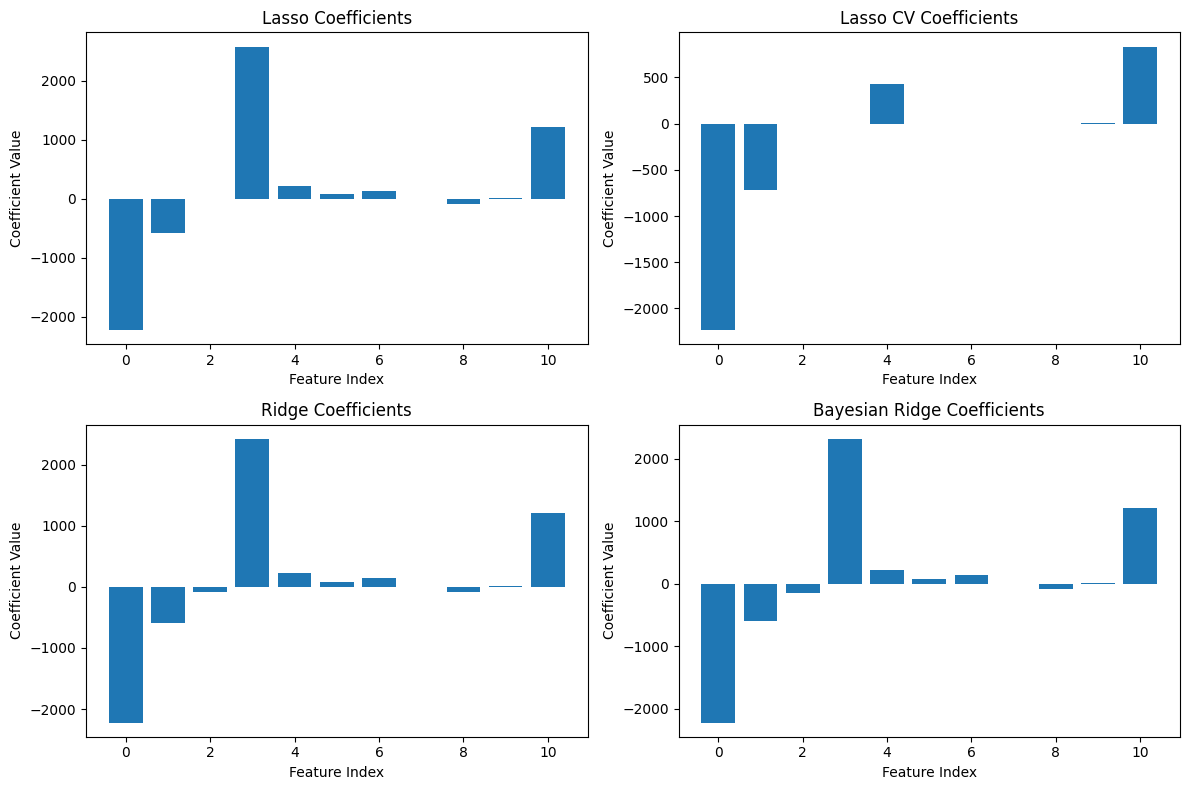

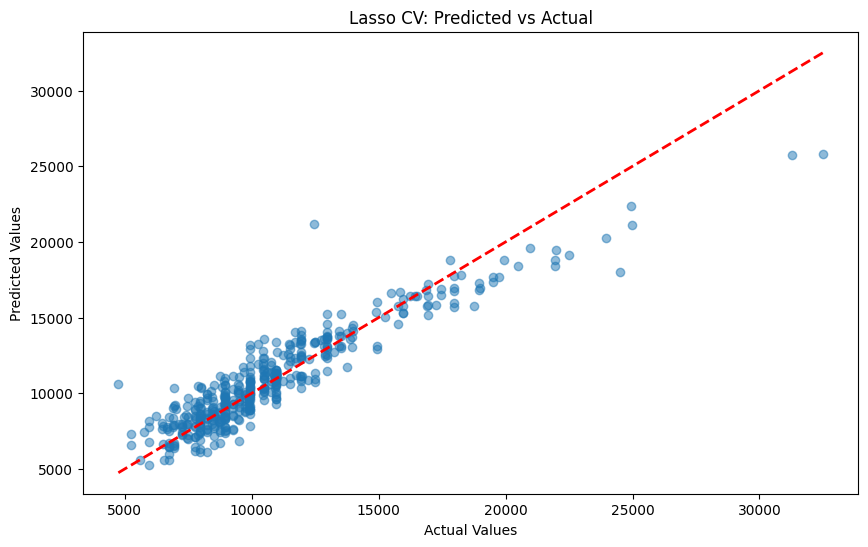

In [ ]:
# Plotting
plt.figure(figsize=(12, 8))

# Plot coefficients for each model
plt.subplot(2, 2, 1)
plt.bar(range(len(lasso.coef_)), lasso.coef_)
plt.title("Lasso Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 2, 2)
plt.bar(range(len(lasso_cv.coef_)), lasso_cv.coef_)
plt.title("Lasso CV Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 2, 3)
plt.bar(range(len(ridge.coef_)), ridge.coef_)
plt.title("Ridge Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")

plt.subplot(2, 2, 4)
plt.bar(range(len(bayesianRidge.coef_)), bayesianRidge.coef_)
plt.title("Bayesian Ridge Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")

plt.tight_layout()
plt.show()

# Plot predictions vs actual for Lasso CV (as an example)
plt.figure(figsize=(10, 6))
plt.scatter(valid_y, lasso_cv.predict(valid_X), alpha=0.5)
plt.plot([valid_y.min(), valid_y.max()], [valid_y.min(), valid_y.max()], 'r--', lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso CV: Predicted vs Actual")
plt.show()

Linear Regression Results:

Regression statistics

                      Mean Error (ME) : -103.5613
       Root Mean Squared Error (RMSE) : 1403.5975
            Mean Absolute Error (MAE) : 968.3501
          Mean Percentage Error (MPE) : -2.2983
Mean Absolute Percentage Error (MAPE) : 9.4610
Linear Regression Coefficients:
Age_08_04: -2224.5168
KM: -584.6822
Fuel_Type_Diesel: 130.0275
Fuel_Type_Petrol: 2721.9819
HP: 218.3116
Met_Color: 79.8155
Automatic: 146.3296
CC: -9.8352
Doors: -95.3719
Quarterly_Tax: 12.8519
Weight: 1219.9706

Lasso Regression Results:

Regression statistics

                      Mean Error (ME) : -104.7963
       Root Mean Squared Error (RMSE) : 1403.3557
            Mean Absolute Error (MAE) : 968.5316
          Mean Percentage Error (MPE) : -2.3165
Mean Absolute Percentage Error (MAPE) : 9.4638
Lasso Regression Coefficients:
Age_08_04: -2223.1098
KM: -587.6956
Fuel_Type_Diesel: 0.0000
Fuel_Type_Petrol: 2575.2643
HP: 216.0145
Met_Color: 75.5504
Automatic: 125

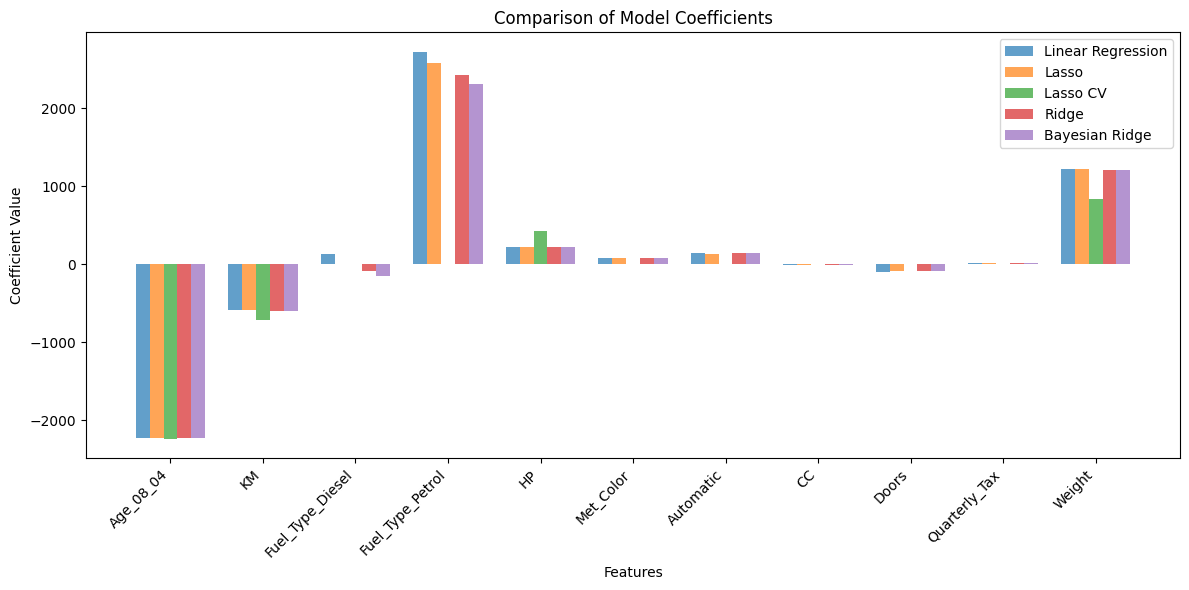

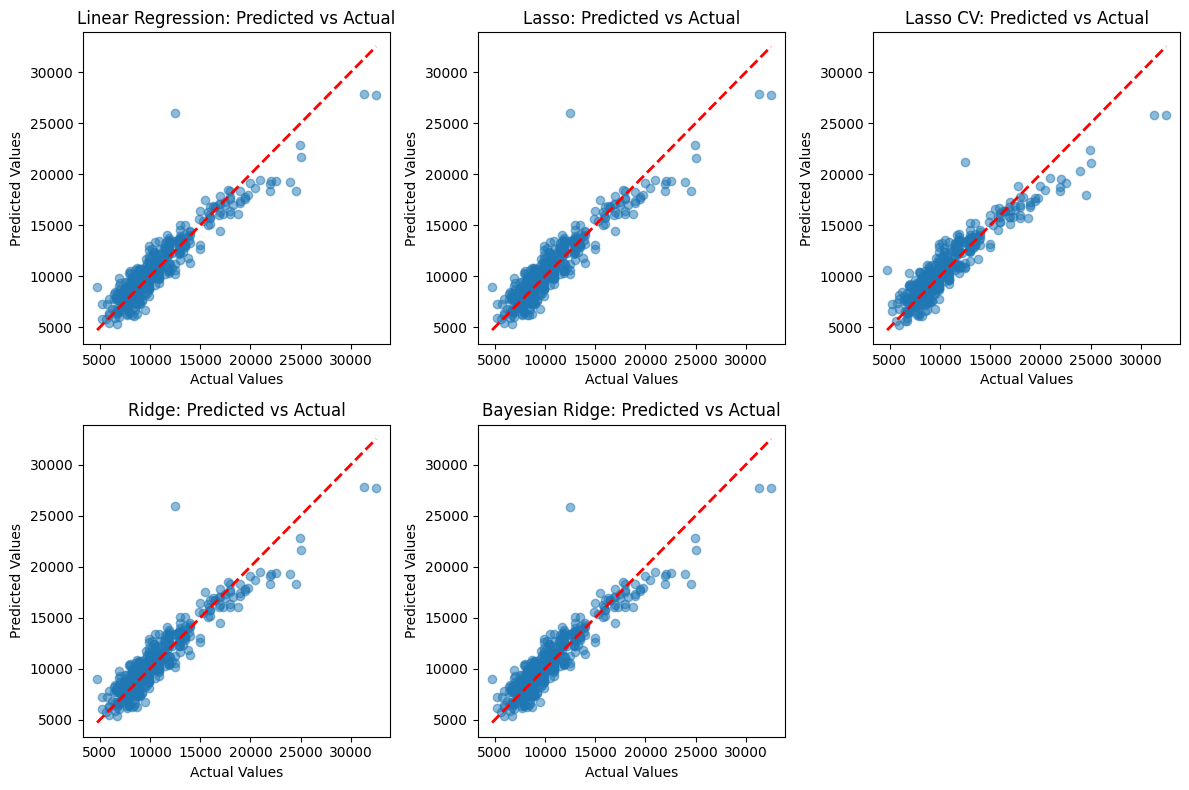

In [ ]:
# Function to print coefficients
def print_coefficients(model, feature_names):
    for name, coef in zip(feature_names, model.coef_):
        print(f"{name}: {coef:.4f}")

# Function to plot coefficients
def plot_coefficients(models, model_names, feature_names):
    n_models = len(models)
    n_features = len(feature_names)

    fig, ax = plt.subplots(figsize=(12, 6))

    bar_width = 0.15
    index = np.arange(n_features)

    for i, (model, name) in enumerate(zip(models, model_names)):
        ax.bar(index + i*bar_width, model.coef_, bar_width, label=name, alpha=0.7)

    ax.set_xlabel('Features')
    ax.set_ylabel('Coefficient Value')
    ax.set_title('Comparison of Model Coefficients')
    ax.set_xticks(index + bar_width * (n_models-1) / 2)
    ax.set_xticklabels(feature_names, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

feature_names = train_X.columns.tolist()
# Linear Regression (as baseline)
lr = LinearRegression()
lr.fit(train_X, train_y)
print("Linear Regression Results:")
regressionSummary(valid_y, lr.predict(valid_X))
print("Linear Regression Coefficients:")
print_coefficients(lr, feature_names)

# Lasso Regression
lasso = Lasso(alpha=1)
lasso.fit(train_X, train_y)
print("\nLasso Regression Results:")
regressionSummary(valid_y, lasso.predict(valid_X))
print("Lasso Regression Coefficients:")
print_coefficients(lasso, feature_names)

# Lasso CV
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(train_X, train_y)
print("\nLasso CV Results:")
regressionSummary(valid_y, lasso_cv.predict(valid_X))
print(f'Lasso-CV chosen regularization: {lasso_cv.alpha_:.4f}')
print("Lasso CV Coefficients:")
print_coefficients(lasso_cv, feature_names)

# Ridge Regression
ridge = Ridge(alpha=1)
ridge.fit(train_X, train_y)
print("\nRidge Regression Results:")
regressionSummary(valid_y, ridge.predict(valid_X))
print("Ridge Regression Coefficients:")
print_coefficients(ridge, feature_names)

# Bayesian Ridge Regression
bayesianRidge = BayesianRidge()
bayesianRidge.fit(train_X, train_y)
print("\nBayesian Ridge Regression Results:")
regressionSummary(valid_y, bayesianRidge.predict(valid_X))
print(f'Bayesian ridge chosen regularization: {bayesianRidge.lambda_ / bayesianRidge.alpha_:.4f}')
print("Bayesian Ridge Regression Coefficients:")
print_coefficients(bayesianRidge, feature_names)

# Plot coefficients for all models
models = [lr, lasso, lasso_cv, ridge, bayesianRidge]
model_names = ['Linear Regression', 'Lasso', 'Lasso CV', 'Ridge', 'Bayesian Ridge']
plot_coefficients(models, model_names, feature_names)

# Plot predictions vs actual for all models
plt.figure(figsize=(12, 8))
for i, (model, name) in enumerate(zip(models, model_names), 1):
    plt.subplot(2, 3, i)
    plt.scatter(valid_y, model.predict(valid_X), alpha=0.5)
    plt.plot([valid_y.min(), valid_y.max()], [valid_y.min(), valid_y.max()], 'r--', lw=2)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{name}: Predicted vs Actual")

plt.tight_layout()
plt.show()

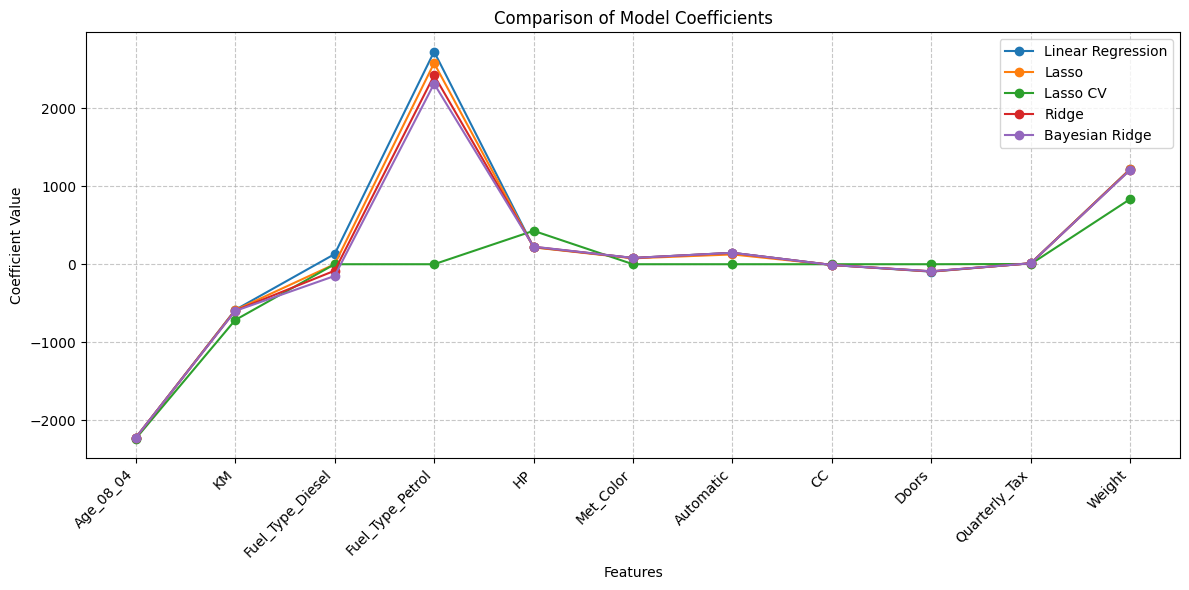

In [ ]:


def plot_coefficients(models, model_names, feature_names):
    plt.figure(figsize=(12, 6))

    for model, name in zip(models, model_names):
        plt.plot(feature_names, model.coef_, marker='o', label=name)

    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title('Comparison of Model Coefficients')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



# Plot coefficients for all models
models = [lr, lasso, lasso_cv, ridge, bayesianRidge]
model_names = ['Linear Regression', 'Lasso', 'Lasso CV', 'Ridge', 'Bayesian Ridge']
plot_coefficients(models, model_names, feature_names)



In [ ]:
# run a linear regression of Price on the remaining 11 predictors in the training set
train_df = train_X.join(train_y)

predictors = train_X.columns
formula = 'Price ~ ' + ' + '.join(predictors)

car_lm = sm.ols(formula=formula, data=train_df).fit()
print(car_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     615.0
Date:                Mon, 07 Oct 2024   Prob (F-statistic):               0.00
Time:                        20:17:39   Log-Likelihood:                -8616.9
No. Observations:                1005   AIC:                         1.726e+04
Df Residuals:                     993   BIC:                         1.732e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

1. Model Fit:
* R-squared: shows the variance (%) in the Price is explained by the predictors.
* Adj. R-squared: similar to R-squared but adjusted for the number of predictors.
* F-statistic: 535.5 with a p-value of 0.00 indicates that the model as a whole is statistically significant.

2. Coefficients:
* Each row represents a predictor variable. Let's interpret a few:
** Intercept: 6619.7731 is the expected price when all other variables are zero.
** Fuel_Type_Diesel[T.True]: 4481.0887 means diesel cars are on average €4,481 more expensive than the reference category (likely gasoline), all else being equal.
** Age_08_04: -2307.6463 indicates that for each unit increase in age, the price decreases by €2,307.65 on average.
** KM: -602.1024 suggests that for each unit increase in kilometers, the price decreases by €602.10 on average.
** HP: 1131.4147 means that for each unit increase in horsepower, the price increases by €1,131.41 on average.

3. Statistical Significance:
Look at the P>|t| column. Values less than 0.05 are typically considered statistically significant. Most variables here are significant, except for Met_Color (p=0.624) and Doors (p=0.265).

4. Confidence Intervals:
The [0.025] and [0.975] columns show the 95% confidence interval for each coefficient.

5. Diagnostics:
* Durbin-Watson: 2.018 is close to 2, suggesting no significant autocorrelation in the residuals.
* Jarque-Bera (JB): A high value with a very low probability suggests the residuals may not be normally distributed.
* Condition Number: 2.01e+03 is quite high, indicating potential multicollinearity issues.


**Key Takeaways:**

* The model explains a large portion of the variance in car prices (87.4%).

* Age, kilometers, and horsepower are among the strongest predictors of price.
* Diesel cars command a premium over other fuel types.

* Some variables (Met_Color, Doors) don't seem to significantly affect the price.
* There might be multicollinearity issues, suggesting some predictors could be correlated with each other.